In [1]:
import pandas as pd
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# for results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

pd.set_option("display.max_rows", 10)

In [2]:
# import DNN & initial setting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [3]:
# load data
division = 'm'  # s or m (s = small-sized meeting room, m = medium-sized seminar room)

# session 1
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess1\P=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess1\P=*.csv')
l.sort()

df_fea_sess1 = []
for i in l:
    df_fea_sess1.append(pd.read_csv(i, header=None))

# session 2
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess2\P=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess2\P=*.csv')
l.sort()

df_fea_sess2 = []
for i in l:
    df_fea_sess2.append(pd.read_csv(i, header=None))
    
# session 3
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess3\P=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess3\P=*.csv')
l.sort()

df_fea_sess3 = []
for i in l:
    df_fea_sess3.append(pd.read_csv(i, header=None))

In [4]:
l

['..\\..\\datasets\\medium-room\\sess3\\P=0.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=1.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=10.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=2.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=3.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=4.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=5.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=6.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=7.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=8.csv',
 '..\\..\\datasets\\medium-room\\sess3\\P=9.csv']

In [5]:
# In case of medium-room, bring P=10 dataset to behind

if division == 'm':
    # session 1
    temp1 = df_fea_sess1[2]
    del df_fea_sess1[2]
    df_fea_sess1.append(temp1)

    # session 2
    temp2 = df_fea_sess2[2]
    del df_fea_sess2[2]
    df_fea_sess2.append(temp2)

    # session 3
    temp3 = df_fea_sess3[2]
    del df_fea_sess3[2]
    df_fea_sess3.append(temp3)
    
    print('done.')

done.


In [8]:
# select session (sess1, sess2, sess3)

df_fea = df_fea_sess1

In [9]:
df_fea[0].shape

(199, 420)

In [10]:
# create column label (feature name)
# l(N1)_xxx(N2) >> N1: link number, N2: subcarrier number.

nof_link = 4
nof_usedsubc = 13

col_label = []

for i in range(nof_link):
    
    for j in range(nof_usedsubc):
        col_label.append('l%d_std%d' %(i+1,j+1))
        col_label.append('l%d_min%d' %(i+1,j+1))
        col_label.append('l%d_max%d' %(i+1,j+1))
        col_label.append('l%d_qtl%d' %(i+1,j+1))
        col_label.append('l%d_qtu%d' %(i+1,j+1))
        col_label.append('l%d_avg%d' %(i+1,j+1))
        col_label.append('l%d_iqr%d' %(i+1,j+1))
        
    for j in range(nof_usedsubc-1):
        col_label.append('l%d_adj%d' %(i+1,j+1))
        
    col_label.append('l%d_euc' %(i+1))
    col_label.append('l%d_rss' %(i+1))

len(col_label)

420

In [11]:
# change column label

for i in range(len(df_fea)):
    df_fea[i].columns = col_label

In [12]:
df_fea[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj5,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,3.255593,2.824882,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,3.329217,2.945392,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,3.390512,3.144561,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,3.327382,3.027890,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,3.273700,2.818021,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.557364,0.595671,0.593804,0.563037,0.548741,0.606306,0.674505,0.647142,0.726399,0.593987,...,3.307183,2.801403,1.189689,1.282997,2.137156,2.988761,2.181092,1.526116,1.288780,0.725632
195,0.583639,0.645127,0.609895,0.606136,0.579689,0.601357,0.697142,0.642774,0.712564,0.646622,...,3.303011,2.668910,1.218117,1.258081,2.072770,2.904706,2.106952,1.512701,1.255239,0.702359
196,0.577348,0.635703,0.549147,0.604853,0.563156,0.571387,0.723391,0.605568,0.731006,0.609101,...,3.350651,2.741673,1.257348,1.404358,2.172586,2.934249,2.287955,1.567191,1.305473,0.795444
197,0.575806,0.561338,0.514700,0.622597,0.538869,0.555903,0.657174,0.621989,0.704929,0.615367,...,3.331872,2.715729,1.351905,1.310305,2.124697,2.953141,2.285298,1.664113,1.331436,0.663437


In [13]:
# Ground truth

for i in range(len(df_fea)):
    df_fea[i]['P'] = i

In [14]:
df_fea[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,P
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,2.824882,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346,0
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,2.945392,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633,0
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,3.144561,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579,0
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,3.027890,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008,0
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,2.818021,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.557364,0.595671,0.593804,0.563037,0.548741,0.606306,0.674505,0.647142,0.726399,0.593987,...,2.801403,1.189689,1.282997,2.137156,2.988761,2.181092,1.526116,1.288780,0.725632,0
195,0.583639,0.645127,0.609895,0.606136,0.579689,0.601357,0.697142,0.642774,0.712564,0.646622,...,2.668910,1.218117,1.258081,2.072770,2.904706,2.106952,1.512701,1.255239,0.702359,0
196,0.577348,0.635703,0.549147,0.604853,0.563156,0.571387,0.723391,0.605568,0.731006,0.609101,...,2.741673,1.257348,1.404358,2.172586,2.934249,2.287955,1.567191,1.305473,0.795444,0
197,0.575806,0.561338,0.514700,0.622597,0.538869,0.555903,0.657174,0.621989,0.704929,0.615367,...,2.715729,1.351905,1.310305,2.124697,2.953141,2.285298,1.664113,1.331436,0.663437,0


In [15]:
df_fea_all = pd.DataFrame()

for i in range(len(df_fea)):
    df_fea_all = pd.concat([df_fea_all, df_fea[i]], axis=0)

df_fea_all.reset_index(drop=True)

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_iqr1,l1_std2,l1_min2,l1_max2,...,l4_adj6,l4_adj7,l4_adj8,l4_adj9,l4_adj10,l4_adj11,l4_adj12,l4_euc,l4_rss,P
0,0.508360,0.556233,0.547783,0.554438,0.538969,0.528093,0.595343,0.578696,0.637909,0.631446,...,2.824882,1.398378,1.429693,2.379176,2.900677,2.177376,1.711222,1.581755,0.514346,0
1,0.485241,0.579260,0.549776,0.535239,0.512745,0.543510,0.614083,0.611247,0.662962,0.590504,...,2.945392,1.482271,1.529019,2.439519,2.971721,2.243851,1.673655,1.701424,0.472633,0
2,0.523973,0.615076,0.563608,0.577708,0.536653,0.565550,0.661444,0.643379,0.719187,0.600445,...,3.144561,1.535579,1.655584,2.537666,3.056356,2.314811,1.652796,1.740957,0.570579,0
3,0.521867,0.585397,0.514375,0.554391,0.509185,0.557026,0.588465,0.606894,0.623689,0.568644,...,3.027890,1.446881,1.501696,2.350605,3.039381,2.209710,1.695750,1.661805,0.603008,0
4,0.520318,0.607385,0.544917,0.574134,0.548106,0.562364,0.583918,0.614920,0.654618,0.599471,...,2.818021,1.362363,1.330560,2.080632,2.943398,2.176994,1.660822,1.575143,0.435911,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,0.917898,0.919850,0.856698,0.804004,0.727550,0.679315,0.650399,0.645671,0.707827,0.656676,...,4.454451,2.749956,2.607276,3.803033,2.618672,4.155710,1.962209,4.423469,3.771152,10
2185,0.993171,1.055292,0.918394,0.886796,0.840524,0.783448,0.783273,0.697142,0.768202,0.650290,...,4.439517,3.112935,2.914972,3.582024,2.502279,4.593882,2.161841,4.788501,3.268520,10
2186,0.913375,1.006806,1.072936,1.082991,1.013199,0.927840,0.883479,0.827988,0.818503,0.758421,...,4.656702,2.967989,2.856366,3.668633,2.768351,4.650457,2.228464,5.654283,3.655176,10
2187,0.987489,1.093021,1.092624,1.122730,1.011742,0.943294,0.923651,0.845975,0.821050,0.787015,...,4.555711,2.941429,2.859348,3.872804,2.970375,4.116094,2.294561,5.577052,3.980606,10


In [16]:
# set k for k-hold cross-validation
k = 7
skf = StratifiedKFold(n_splits=k)

X = df_fea_all.drop('P', axis=1)
y = df_fea_all['P']

X = X.reset_index()
X = X.drop('index', axis = 1)
y = y.reset_index()
y = y.drop('index', axis = 1)

train_index = [[] for _ in range(k)]
test_index = [[] for _ in range(k)]

n = 0
for tra_idx, tes_idx in skf.split(X,y):
    
    print('##### Stratified k-fold',n+1,'回目 #####')
    print("TRAIN: ",len(tra_idx))
    print("TEST: ",len(tes_idx))
    
    train_index[n] = tra_idx
    test_index[n] = tes_idx
    
    n += 1

##### Stratified k-fold 1 回目 #####
TRAIN:  1876
TEST:  313
##### Stratified k-fold 2 回目 #####
TRAIN:  1876
TEST:  313
##### Stratified k-fold 3 回目 #####
TRAIN:  1876
TEST:  313
##### Stratified k-fold 4 回目 #####
TRAIN:  1876
TEST:  313
##### Stratified k-fold 5 回目 #####
TRAIN:  1876
TEST:  313
##### Stratified k-fold 6 回目 #####
TRAIN:  1877
TEST:  312
##### Stratified k-fold 7 回目 #####
TRAIN:  1877
TEST:  312


In [ ]:
# early stopping setting
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

2022-02-14 15:03:50.513162
Epoch 1/1000
17/17 [==============================] - 1s 13ms/step - loss: 4.5984 - mae: 1.4248 - val_loss: 1.1869 - val_mae: 0.8209
Epoch 2/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.7435 - mae: 0.6540 - val_loss: 0.4585 - val_mae: 0.5192
Epoch 3/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.3480 - mae: 0.4488 - val_loss: 0.3487 - val_mae: 0.4594
Epoch 4/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.2374 - mae: 0.3678 - val_loss: 0.2637 - val_mae: 0.3827
Epoch 5/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.1799 - mae: 0.3166 - val_loss: 0.2435 - val_mae: 0.3732
Epoch 6/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.1384 - mae: 0.2737 - val_loss: 0.2345 - val_mae: 0.3541
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1017 - mae: 0.2334 - val_loss: 0.2230 - val_mae: 0.3535
Epoch 8/1000
17/17 [============================

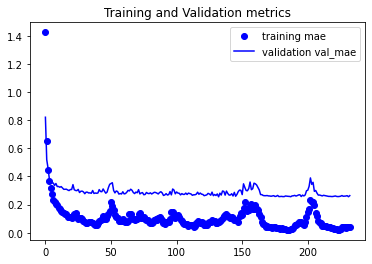

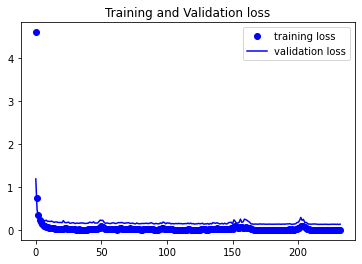

Epoch 1/1000
17/17 [==============================] - 0s 12ms/step - loss: 5.2349 - mae: 1.5179 - val_loss: 1.0161 - val_mae: 0.7889
Epoch 2/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.8459 - mae: 0.6906 - val_loss: 0.4961 - val_mae: 0.5249
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.4430 - mae: 0.4944 - val_loss: 0.3404 - val_mae: 0.4422
Epoch 4/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.2933 - mae: 0.3952 - val_loss: 0.2652 - val_mae: 0.3811
Epoch 5/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.2420 - mae: 0.3622 - val_loss: 0.2754 - val_mae: 0.3879
Epoch 6/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1822 - mae: 0.3109 - val_loss: 0.2706 - val_mae: 0.3788
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1668 - mae: 0.2957 - val_loss: 0.2130 - val_mae: 0.3521
Epoch 8/1000
17/17 [==============================] - 0s 6ms/step - loss: 0

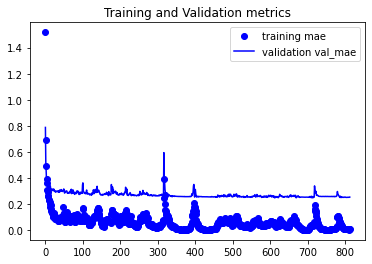

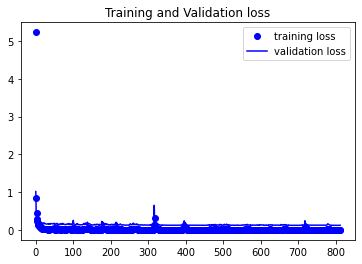

Epoch 1/1000
17/17 [==============================] - 0s 11ms/step - loss: 5.5411 - mae: 1.5548 - val_loss: 1.4361 - val_mae: 0.9071
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.9097 - mae: 0.7079 - val_loss: 0.5557 - val_mae: 0.5662
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.4242 - mae: 0.4846 - val_loss: 0.4122 - val_mae: 0.4620
Epoch 4/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.3355 - mae: 0.4236 - val_loss: 0.2916 - val_mae: 0.3864
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2472 - mae: 0.3693 - val_loss: 0.2631 - val_mae: 0.3695
Epoch 6/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1789 - mae: 0.3115 - val_loss: 0.2472 - val_mae: 0.3581
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1537 - mae: 0.2862 - val_loss: 0.2649 - val_mae: 0.3670
Epoch 8/1000
17/17 [==============================] - 0s 6ms/step - loss: 0

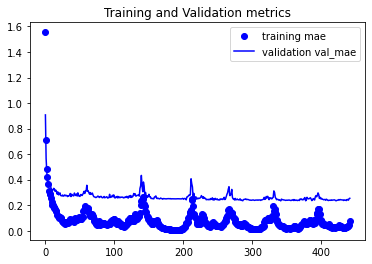

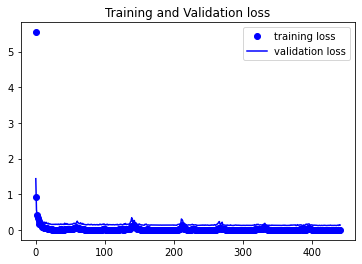

Epoch 1/1000
17/17 [==============================] - 0s 11ms/step - loss: 4.9726 - mae: 1.4588 - val_loss: 0.8121 - val_mae: 0.7008
Epoch 2/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.7919 - mae: 0.6586 - val_loss: 0.5729 - val_mae: 0.5456
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.3894 - mae: 0.4682 - val_loss: 0.3479 - val_mae: 0.4462
Epoch 4/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2679 - mae: 0.3929 - val_loss: 0.2823 - val_mae: 0.3987
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2024 - mae: 0.3364 - val_loss: 0.2537 - val_mae: 0.3751
Epoch 6/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.1572 - mae: 0.2941 - val_loss: 0.2515 - val_mae: 0.3634
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1265 - mae: 0.2662 - val_loss: 0.2305 - val_mae: 0.3593
Epoch 8/1000
17/17 [==============================] - 0s 6ms/step - loss: 0

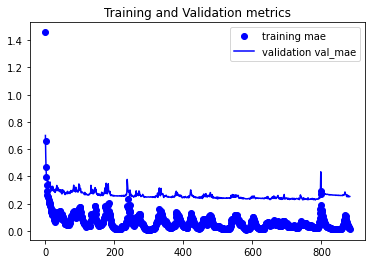

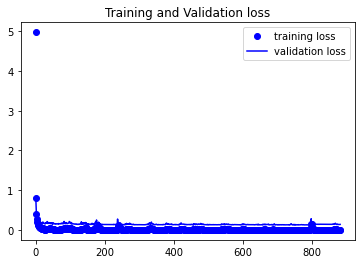

Epoch 1/1000
17/17 [==============================] - 0s 13ms/step - loss: 5.3098 - mae: 1.5500 - val_loss: 1.3218 - val_mae: 0.7999
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 1.1110 - mae: 0.7839 - val_loss: 0.7158 - val_mae: 0.6631
Epoch 3/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.6063 - mae: 0.5835 - val_loss: 0.4179 - val_mae: 0.4920
Epoch 4/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.4126 - mae: 0.4913 - val_loss: 0.3686 - val_mae: 0.4609
Epoch 5/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.2887 - mae: 0.4118 - val_loss: 0.2953 - val_mae: 0.4022
Epoch 6/1000
17/17 [==============================] - 0s 7ms/step - loss: 0.2234 - mae: 0.3626 - val_loss: 0.2638 - val_mae: 0.3800
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1889 - mae: 0.3298 - val_loss: 0.2611 - val_mae: 0.3955
Epoch 8/1000
17/17 [==============================] - 0s 6ms/step - loss: 0

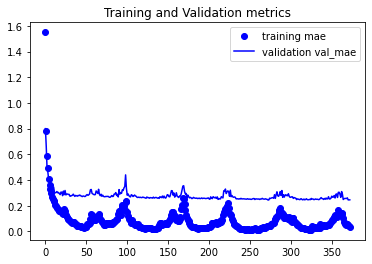

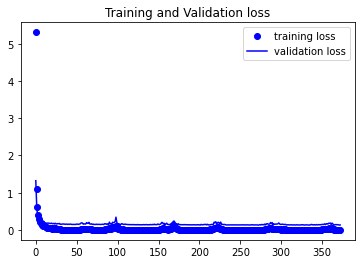

Epoch 1/1000
17/17 [==============================] - 0s 11ms/step - loss: 6.1497 - mae: 1.6867 - val_loss: 1.2392 - val_mae: 0.8419
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.7999 - mae: 0.6833 - val_loss: 0.4740 - val_mae: 0.5060
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.3989 - mae: 0.4822 - val_loss: 0.4281 - val_mae: 0.4914
Epoch 4/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2845 - mae: 0.3996 - val_loss: 0.3210 - val_mae: 0.4151
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2310 - mae: 0.3565 - val_loss: 0.2878 - val_mae: 0.3932
Epoch 6/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1874 - mae: 0.3215 - val_loss: 0.2595 - val_mae: 0.3566
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1632 - mae: 0.3010 - val_loss: 0.2450 - val_mae: 0.3631
Epoch 8/1000
17/17 [==============================] - 0s 6ms/step - loss: 0

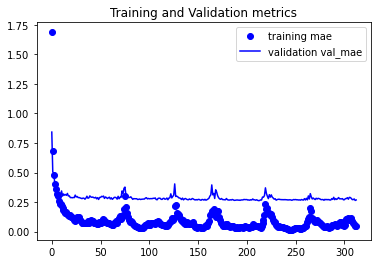

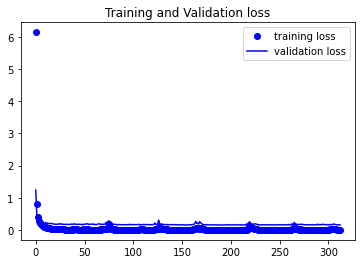

Epoch 1/1000
17/17 [==============================] - 0s 11ms/step - loss: 6.0809 - mae: 1.6037 - val_loss: 1.1784 - val_mae: 0.8061
Epoch 2/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.7415 - mae: 0.6376 - val_loss: 0.5671 - val_mae: 0.5841
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.4093 - mae: 0.4833 - val_loss: 0.3616 - val_mae: 0.4448
Epoch 4/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2849 - mae: 0.4099 - val_loss: 0.2956 - val_mae: 0.4108
Epoch 5/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.2215 - mae: 0.3637 - val_loss: 0.2516 - val_mae: 0.3743
Epoch 6/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1767 - mae: 0.3228 - val_loss: 0.2142 - val_mae: 0.3425
Epoch 7/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.1550 - mae: 0.3041 - val_loss: 0.2196 - val_mae: 0.3633
Epoch 8/1000
17/17 [==============================] - 0s 6ms/step - loss: 0

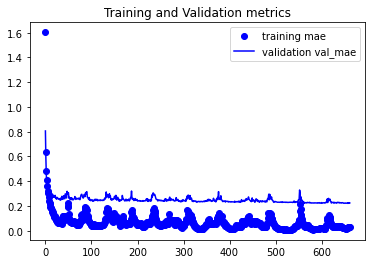

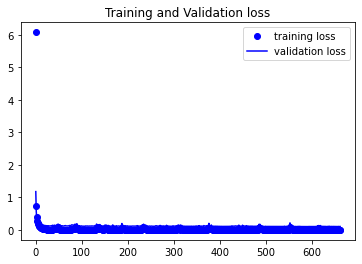

2022-02-14 15:10:44.073549


In [17]:
# learning

y_test_list = [[] for _ in range(k)]
y_pred_list = [[] for _ in range(k)]

print(datetime.datetime.now())

for i in range(k):
    
    X_train = X.iloc[train_index[i]]
    X_test = X.iloc[test_index[i]]
    y_train = y.iloc[train_index[i]]
    y_test = y.iloc[test_index[i]]
    
    # valdation data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)
    
    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)
    X_test = pd.DataFrame(X_test)
    
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(optimizer=opt,  
                  loss='mse', 
                  metrics=['mae'])
    
    # fit
    history = model.fit(X_train, y_train,  
                        batch_size=100,  
                        epochs=1000,      
                        verbose=1,       
                        validation_data=(X_val, y_val),  
                        callbacks=(early_stopping))
    
    # prediction
    y_pred = model.predict(X_test)
    
    y_test_list[i] = y_test
    y_pred_list[i] = y_pred
    
    print(i+1)
    
    compare_TV(history, "mae", "val_mae")
    
print(datetime.datetime.now())

In [18]:
for i in range(len(y_test_list)):
    y_test_list[i] = y_test_list[i].values

In [19]:
y_test_tot = []
y_pred_tot = []

for i in range(k):
    y_test_tot.extend(y_test_list[i])
    y_pred_tot.extend(y_pred_list[i])

In [21]:
# result scores

print('DNN')
print('###########################')
print('Med-abs-err: ',round(median_absolute_error(y_test_tot, y_pred_tot),4))
print('Max-err: ',round(max_error(y_test_tot, y_pred_tot),4))
print('R2_score: ',round(r2_score(y_test_tot, y_pred_tot),4))
print('###########################')

DNN
###########################
Med-abs-err:  0.2862
Max-err:  3.8897
R2_score:  0.9686
###########################
